# Lab 2: Ice Flux Divergences

### Load data from the csv file you generated

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Topography
df = pd.read_csv('../data/KohlerPopeSmith.csv')
print(df.columns)

Index(['x', 'y', 'surf', 'bed', 'velx', 'vely', 'smb', 'dhdt', 'highvel_mask',
       'bedmap_mask', 'bedmap_surf', 'bedmachine_source',
       'bedmachine_thickness', 'bedmap_bed'],
      dtype='object')


Let's have a little practice time! Loading and plotting data is a very useful skill, no matter what major you has and what fields you want to work in. Now, as we have the convenient csv file from Lab 1, lets load data

__Q1: Load the csv file into a pandas dataframe. Plot following data: ice velocity magnitude, surface mass balance, surface elevation change rate, ice surface elevation__

hint: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html, scroll down to the bottom

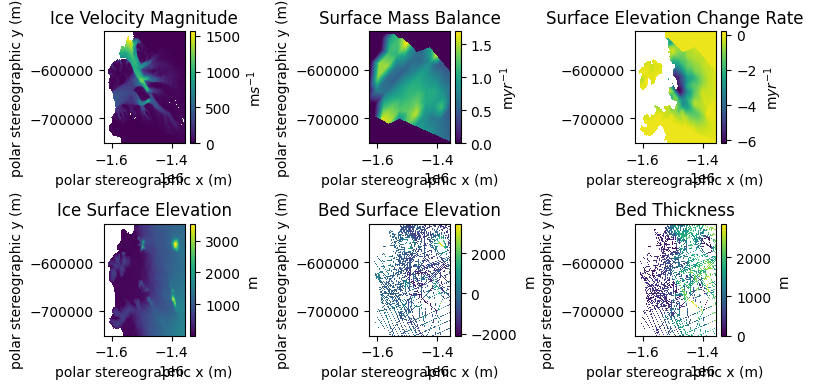

In [2]:
xx, yy = np.meshgrid(np.unique(df.x), np.unique(df.y))

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(8,4)

# ice velocity magnitude
fig.colorbar(
    axs[0,0].pcolormesh(xx,yy,np.sqrt(df['velx']**2 + df['vely']**2).values.reshape(xx.shape)), 
).set_label(r'm$s^{-1}$')
axs[0,0].set_title('Ice Velocity Magnitude')
axs[0,0].set_xlabel('polar stereographic x (m)')
axs[0,0].set_ylabel('polar stereographic y (m)')

# surface mass balance
fig.colorbar(
    axs[0,1].pcolormesh(xx,yy,df['smb'].values.reshape(xx.shape)),
).set_label(r'm$yr^{-1}$')
axs[0,1].set_title('Surface Mass Balance')
axs[0,1].set_xlabel('polar stereographic x (m)')
axs[0,1].set_ylabel('polar stereographic y (m)')

# surface elevation change rate
fig.colorbar(
    axs[0,2].pcolormesh(xx,yy,df['dhdt'].values.reshape(xx.shape))
).set_label(r'm$yr^{-1}$')
axs[0,2].set_title('Surface Elevation Change Rate')
axs[0,2].set_xlabel('polar stereographic x (m)')

# surface elveation
fig.colorbar(
    axs[1,0].pcolormesh(xx,yy,df['surf'].values.reshape(xx.shape)),
).set_label('m')
axs[1,0].set_title('Ice Surface Elevation')
axs[1,0].set_xlabel('polar stereographic x (m)')
axs[1,0].set_ylabel('polar stereographic y (m)')

fig.colorbar(
    axs[1,1].pcolormesh(xx,yy,df['bed'].values.reshape(xx.shape)),
).set_label('m')
axs[1,1].set_title("Bed Surface Elevation")
axs[1,1].set_xlabel('polar stereographic x (m)')
axs[1,1].set_ylabel('polar stereographic y (m)')

fig.colorbar(
    axs[1,2].pcolormesh(xx,yy,(df['surf'] - df['bed']).values.reshape(xx.shape)),
).set_label('m')
axs[1,2].set_title("Bed Thickness")
axs[1,2].set_xlabel('polar stereographic x (m)')
axs[1,2].set_ylabel('polar stereographic y (m)')

plt.tight_layout()

### Continuity & Flux

https://www.khanacademy.org/science/ap-college-physics-1/xf557a762645cccc5:fluids/xf557a762645cccc5:fluid-flow/a/what-is-volume-flow-rate

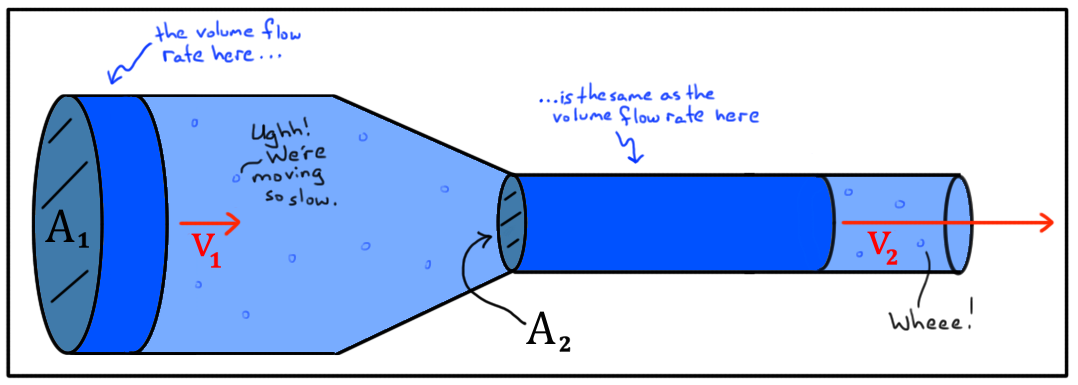

Read through the material, lets do a little mathematical check-in

Water flows steadily through a pipe. At the inlet (where water enter the pipe), the pipe has a diameter of 0.20 m, and the velocity of water is 1.5 m/s. At the exit, the velocity of water increases to 3.0 m/s.

Question: What is the required diameter of the pipe outlet so that the flow is conserved?

In [3]:
pipe_radius_inlet = 0.1
velocity_inlet = 1.5
pipe_area_inlet = np.pi * pipe_radius_inlet**2
flux_inlet =  pipe_area_inlet * velocity_inlet #water volume pass the inlet cross section per second

velocity_outlet = 3
flux_outlet = flux_inlet
pipe_area_outlet = flux_outlet / velocity_outlet
pipe_radius_outlet = np.sqrt(pipe_area_outlet/np.pi)
pipe_radius_outlet = np.sqrt(pipe_area_outlet / np.pi)
pipe_diameter_outlet = 2 * pipe_radius_outlet

print('Calculated pipe area outlet:', pipe_area_outlet)
print('Required pipe outlet diameter:', pipe_diameter_outlet)

Calculated pipe area outlet: 0.015707963267948967
Required pipe outlet diameter: 0.1414213562373095


Answer: pipe_area_outlet = 0.0157 m^2. Please show calculation steps in code

### Ice Flux Divergence

Now lets imagine a column of ice, where the base of the column is a 500 meter by 500 meter square. Assume the ice has a uniform flow in and out of this grid. That is, the velocity of ice didn't change with depth

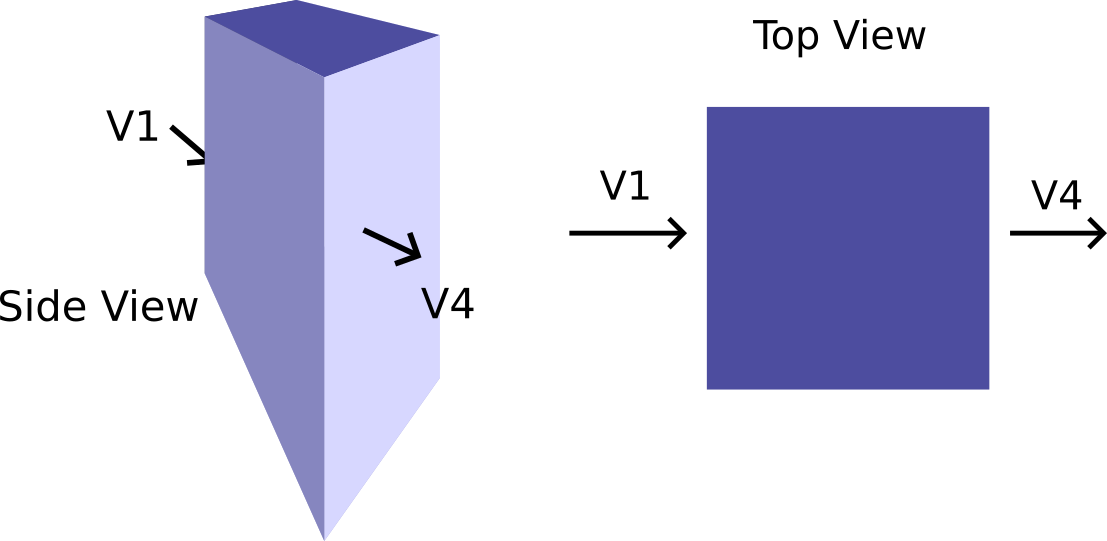

__Q2: what is relationship between v1 (velocity in) and v4 (velocity out) if this column of ice do have have external mass added or substracted and do not have changes in surface elevation?__ Answer in a simple equation

Answer: If the height and mass stay constant, the ice flux entering face 1 must be the same leaving face 4. This means we would have a formula that looks like A * v_1 = A * v_4, where A is the 500m x 500m base of the column

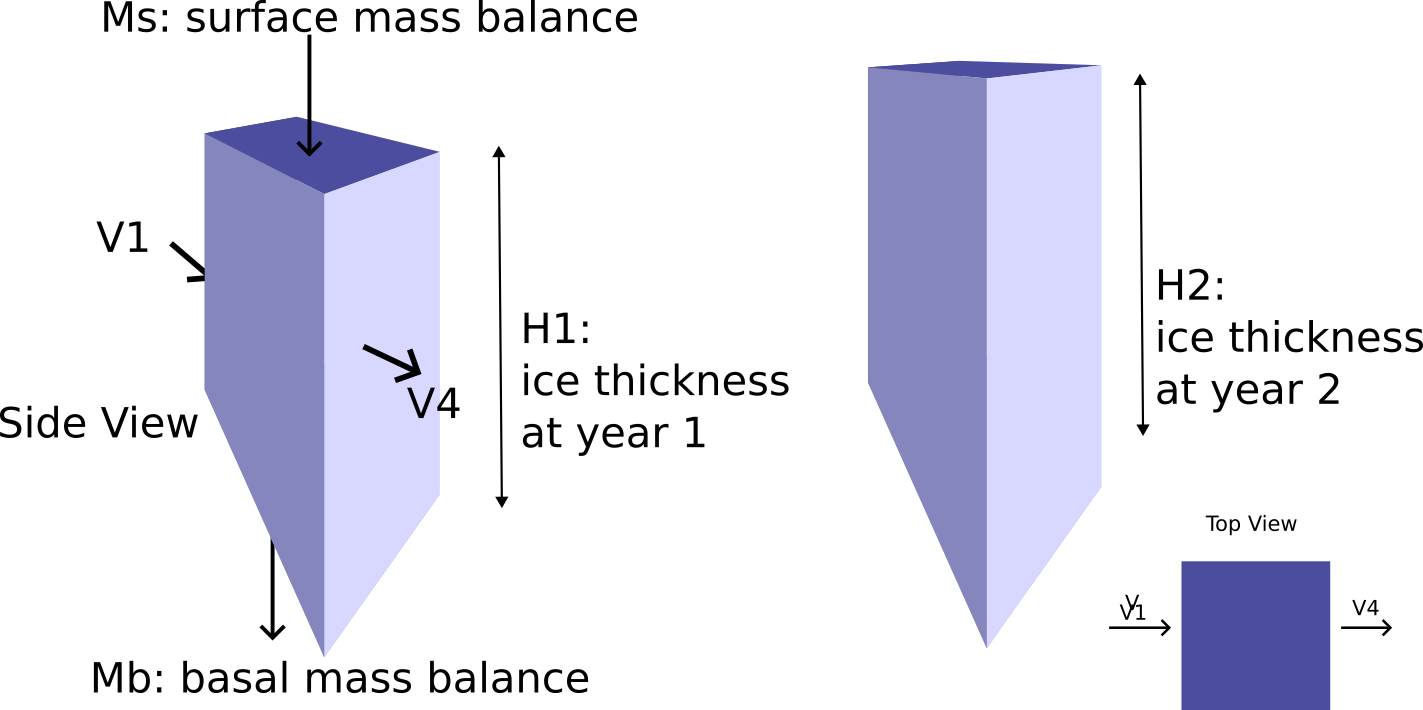

__Challenge! (Optional)__

__What is the relationship between v1, v4, Ms, Mb, H1, and H2?__ Answer in words or in formula

(H2 - H1) = ((v4 - v1) * (H2 - H1)/2) + Ms + Mb

From Tuesday's reading!

### Calculating Mass Flux Residuals

This is the function to calculate the mass flux residuals. Read the function

In [4]:
""" compute the mass conservation residual from topography

Args:
    bed (2D numpy array of float): the elevation of the subglacial topography, in units of meters
    surf (2D numpy array of float): the elevation of the ice surface, in unit of meters
    velx (2D numpy array of float): velocity in the x-direction, in unit of meters per year
    vely (2D numpy array of float): velocity in the y-direction, in unit of meters per year
    dhdt (2D numpy array of float): rate of changes of surface elevation, in unit of meters per year
    smb (2D numpy array of float): annual surface mass balance, in unit of ice-equivalent meters per year
    resolution (int): resolution of the grid.
Returns:
    res: mass conservation residual given the input parameters
"""
def get_mass_conservation_residual(bed, surf, velx, vely, dhdt, smb, resolution):
    thick = surf - bed
    
    dx = np.gradient(velx*thick, resolution, axis=1)
    dy = np.gradient(vely*thick, resolution, axis=0)
    
    res = dx + dy + dhdt - smb
    
    return res

__Q4: read the function, and describe what is the input, and what is the output. Describe the unit of the output (e.g. meters, meters per year, meter-squared per year, etc.))__

Answer: The function get_mass_conservation_residual takes in gridded data for bed elevation, ice surface elevation, ice velocity in the x and y direction, rate of surface elevation change, and surface mass balance. It also takes in a scalar values of the resolution (i.e. the size of each grid cell, 500m x 500m). The function calculates the ice thickness, change in ice flux in the x and y directions, and uses these to calculate the residual, which is returned by the function. The unit of this value is in meters per year (m yr^{-1}). This value represents the mass conservation residual.

In [ ]:
df = pd.read_csv('../data/KohlerPopeSmith.csv')

In [6]:
xx, yy = np.meshgrid(np.unique(df.x), 
                     np.unique(df.y))

surf = df['surf'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)

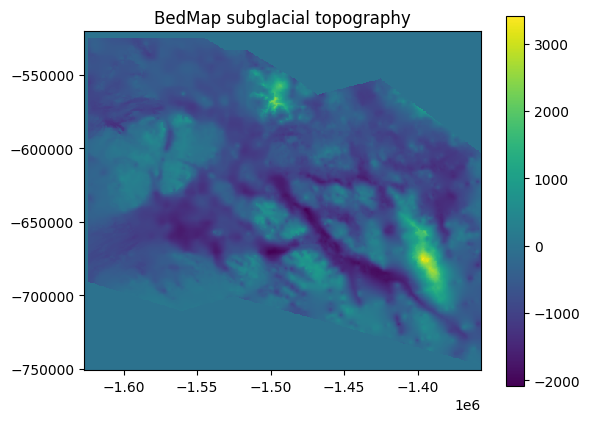

In [7]:
plt.pcolormesh(xx,yy,bedmap_bed)
plt.title('BedMap subglacial topography')
plt.axis('scaled')
plt.colorbar()

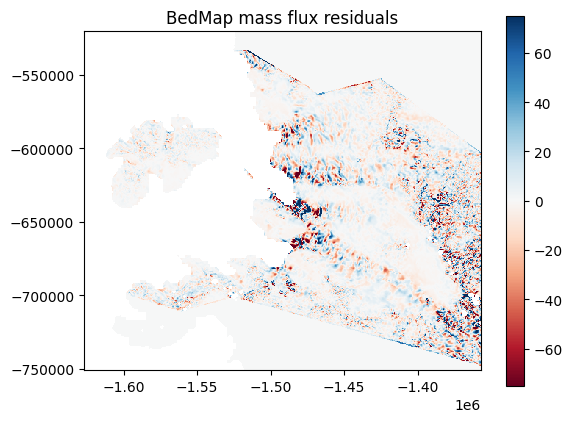

In [8]:
resolution = 500
bedmap_residual = get_mass_conservation_residual(bedmap_bed, surf, velx, vely, dhdt, smb, resolution)

plt.pcolormesh(xx,yy,bedmap_residual,cmap='RdBu',vmax=75,vmin=-75)
plt.title('BedMap mass flux residuals')
plt.axis('scaled')
plt.colorbar()

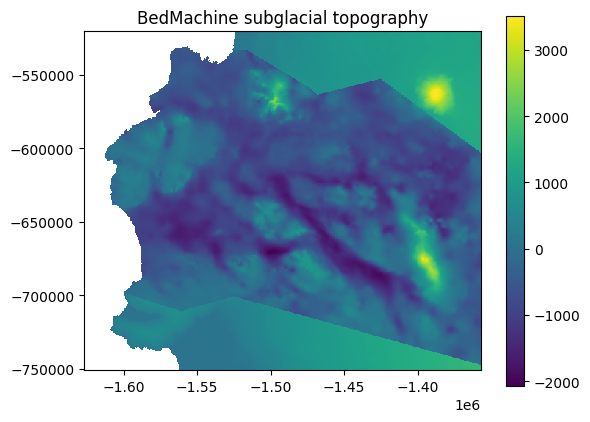

In [9]:
bedmachine_bed = surf - df["bedmachine_thickness"].values.reshape(xx.shape)

plt.pcolormesh(xx,yy,bedmachine_bed)
plt.title('BedMachine subglacial topography')
plt.axis('scaled')
plt.colorbar()

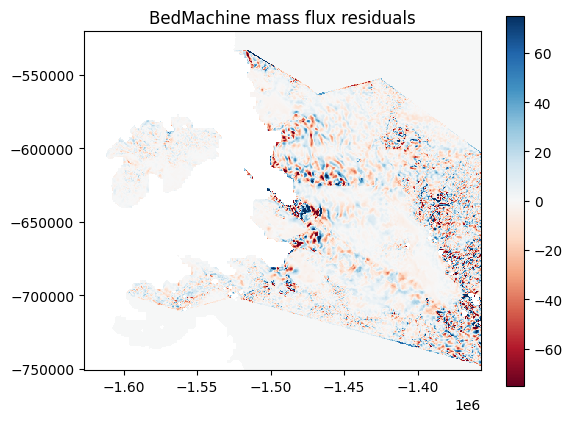

In [10]:
resolution = 500
bedmachine_residual = get_mass_conservation_residual(bedmachine_bed, surf, velx, vely, dhdt, smb, resolution)

plt.pcolormesh(xx,yy,bedmachine_residual,cmap='RdBu',vmax=75,vmin=-75)
plt.title('BedMachine mass flux residuals')
plt.axis('scaled')
plt.colorbar()

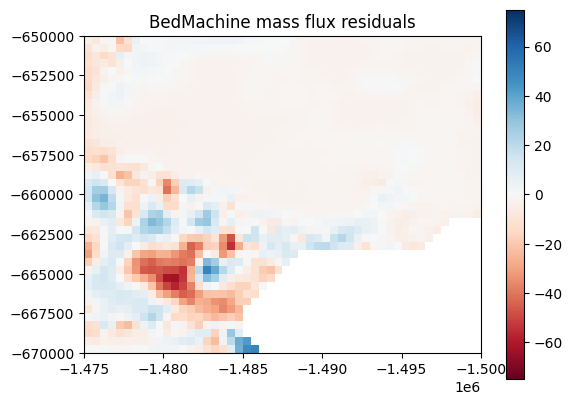

In [11]:
resolution = 1000 # increase resolution
bedmachine_residual = get_mass_conservation_residual(bedmachine_bed, surf, velx, vely, dhdt, smb, resolution)

# Your current plot
plt.pcolormesh(xx, yy, bedmachine_residual, cmap='RdBu', vmax=75, vmin=-75)
plt.title('BedMachine mass flux residuals')
plt.axis('scaled')
plt.colorbar()

# Zoom in on a specific region
plt.xlim(-1475000, -1500000)
plt.ylim(-670000, -650000)

plt.show()


__Q5: What is the difference between the mass flux residuals from BedMap and the mass flux residuals from BedMachine? Why this difference exists?__

Answer: Looking at the plot of the residuals for the entire study area, it is difficult to notice any specific types of patterns. Even when increasing resolution and zooming in on certain regions, it is hard to tell what the residuals look like. Overall, there is a difference between the bedmap and bedmachine mass flux residuals. This is likely because each of the products serves a different purpose. The emphasis of BedMap is on accuracy at the cost of physical realism, whereas the goal of BedMachine is physical realism at the expense of accuracy. The reason why BedMachine's focus is on physical realism is so ice sheet modelers can put the bed interpolations into ice sheet models and get back viable results. This would not be possible with BedMap interpolations, as the results violate the laws of physics. 